# Laboratoire 3 : Machines à vecteur de support et réseaux neuronaux
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | Alexandre Bleau — BLEA14058906 / David Létinaud  — LETD05129708 / Thomas Lioret   — LIOT20069605|
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2019                                            |
| Groupe                | 1                                                       |
| Numéro du laboratoire | 3                                                       |
| Professeur            | Prof. LOMBAERT                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 18/11/2019                                              |

## Introduction

Au cours de ce troisième laboratoire, nous allons étudier deux nouveaux algorithmes d'apprentissage supervisé pour résoudre le problème de classification des galaxies : les réseaux neuronaux et les machines à vecteurs de support (SVM). 
Nous allons également apprendre à utiliser la librairie tensorflow en association avec tensorboard pour pouvoir visualiser en temps réel l'évolution de l'apprentissage du réseau de neurones.
Dans un premier temps, nous allons concevoir un modèle de réseaux neuronaux basé sur le Multi-Layer Perceptron. Nous entrainerons ce modèle afin qu'il puisse classer les galaxies en "smooth" ou "spiral" en utilisant l'ensemble des primitives. Nous utiliserons le module keras de Google tensorflow.
Le deuxième modèle d'apprentissage s'appuie sur un modèle d'optimisation convexe dans le cas du SVM. Dans ce cas, nous n'utiliserons qu'une partie des primitives proposées qui seront couplées à nos primitives développées lors du premier laboratoire.

Nous étudierons notamment l'influence des hyperparamètres de ces deux méthodes afin de proposer le modèle le plus optimal dans le cas de notre problème de classification de galaxies. Nous verrons également l'impact de la taille du dataset sur les performances des modèles.

## Question 1

Dans le cas des réseaux neuronaux, l'utilisation d'une méthode de validation croisée prendrait beaucoup de temps. En effet, il faudrait répéter plusieurs tests avec un nombre "d'epochs" conséquent : ceci serait très chronophage. Nous avons donc décidé d'utiliser la méthode de validation hold-out avec 80% de données d'entrainement et 20% de test.

Concernant le modèle SVM, nous utilisons la méthode de cross validation avec 5 groupes de données (cv=5). Contrairement à Hold-out, la validation croisée effectue plusieurs cycles de validation pour réduire la variabilité. Ainsi, la validation croisée à l'avantage de combiner les mesures de l'aptitude à la prédiction pour obtenir une estimation plus précise de la performance de prédiction du modèle.

## Question 2

Nous normalisons nos données grâce à la méthode "normalize" de la librairie preprocessing. La normalisation se fait par rapport à la valeur maximale. Nous avons décidé de normaliser les primitives indépendamment les unes des autres (axis = 0). Par ailleurs, nous avons remarqué avec nos premiers tests que les performances étaient meilleures si l'on normalise par rapport à la valeur maximale (norm = 'max').

Cette fonction est utilisée dans la procédure "get_data()" dans functions.py de la manière suivante :

X = preprocessing.normalize(X, norm='max',axis = 0)

## Question 3

Nous allons d'abord utiliser un réseau neuronal de type "multilayer perceptron" (MLP).
Celui-ci se compose notamment d'une couche d'entrée, une de sortie et d'une ou plusieurs couches cachées. Ce type de réseau de neurones apprend à classifier par une succession de calculs matriciels qu'on appelle propagation et rétropropagation, ces 2 étapes constituent une epoch. 
Ce modèle possède plusieurs hyperparamètres notamment:
. Le nombre de couches cachées
. Le nombre de perceptrons sur les couches cachées
. Le nombre d'itérations (epochs)
. Le taux d'apprentissage (learning rate)
"Dropout" est également un paramètre important. En effet, celui-ci permet de réduire le surapprentissage d'un réseau neuronal en supprimant temporairement des neurones pendant l'entrainement pour être ensuite réactivé dans la phase de test. Dans notre cas, ce paramètre sera fixé à 0.5 pour les couches cachées. C'est-à-dire qu'on laisse une probabilité de 0.5 de retenir la sortie de chaque noeud.

En machine learning, la fonction coût d'un réseau neuronal mesure la "distance" entre la valeur prédite et la valeur réelle. Ici, la fonction de coût que nous avons choisie est "Binary Cross-Entropy Loss". En effet, nous avons choisi cette fonction, car nos valeurs cibles sont binaires, soit "smooth" ou "spiral".


La principale contrainte du modèle MLP est de trouver un compromis entre le temps d'apprentissage et la précision. La première architecture proposée par l'énoncé est de trois couches cachées : 100, 100, 2 (nombre de perceptrons), 60 epochs et un learning rate de 0.0005. Nous avons étudié différents cas avec 60 epochs :  
1 - l'influence du nombre de perceptrons avec un nombre de couches fixé.  
2 - l'influence du nombre de couches avec le même nombre de perceptrons par couche.  
3 - l'influence du learning rate.

Pour la méthode MLP, les algorithmes ont été executés sur un ordinateur avec les caractéristiques suivantes :

Memoire : 8 Go 1600 MHz DDR3
Processor : 2,6 GHz Intel Core i5 
Graphics : Intel Iris 1536 Mo  

In [6]:
from RN_model import *
from functions import get_data , plot_perf, plot_delay
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard # Pour affichage sur tensorboard
import shutil

In [7]:
# Import and normalize data
X_train, X_test, Y_train, Y_test = get_data()

In [8]:
# Initialisations
layer_sizes = [100, 100, 2]
epochs = 60
learning_rate = 0.0005
batch_size = 100

dropout = 0.5

# Pour affichage
sub_title = ['loss','acc','f1','val_loss','val_acc', 'val_f1']
x_lab = "epochs"

Voici donc nos résultats avec différentes structures de réseaux de neurones :

1 - Influence du nombre de perceptrons:  

In [9]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []

best_accuracy_RN = 0

nb_perceptrons_range = [[5, 4, 4],[100, 100, 2],[500, 500, 500]]                                                                                                                      

# Suppression de la dernière étude d'hyperparamètre
try:
    tf.reset_default_graph()
    shutil.rmtree('./logs')
except:
    print("nothing to delete")
    
# Callbacks pour affichage des performances dans tensorflow : 1 callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(3):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006
cpt = 0
for nb_perceptrons in nb_perceptrons_range:                                                                                                                                                  
    model = RN_model(nb_perceptrons, dropout, learning_rate)                                                                                                                              
    #### Apprentissage                                                                                                                                                             
    start = time.time()                                                                                                                                                            
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]])                                                             

    end = time.time()                                                                                                                                                              
    training_delay_RN.append(end - start)                                                                                                                                          

    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                
    start = time.time()                                                                                                                                                            

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)                                                                                                                           

    end = time.time()                                                                                                                                                              
    predicting_delay_RN.append(end - start)    
    cpt+=1   

nothing to delete
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 12800 samples, validate on 3200 samples
Epoch 1/60
12800/12800 [==============================] - 2s 181us/sample - loss: 0.6938 - acc: 0.5214 - f1: 0.6650 - val_loss: 0.6923 - val_acc: 0.5203 - val_f1: 0.6832
Epoch 2/60
12800/12800 [==============================] - 1s 55us/sample - loss: 0.6826 - acc: 0.5452 - f1: 0.6795 - val_loss: 0.6775 - val_acc: 0.5344 - val_f1: 0.6890
Epoch 3/60
12800/12800 [==============================] - 1s 53us/sample - loss: 0.6546 - acc: 0.5924 - f1: 0.7021 - val_loss: 0.5886 - val_acc: 0.8775 - val_f1: 0.8851
Epoch 4/60
12800/12800 [==============================] - 1s 53us/sample - loss: 0.6283 - acc: 0.5998 - f1: 0.7032 - val_loss: 0.5254 - val_acc: 0.8809 - val_f1: 0.8841
Epoch 5/60
12800/12800 [====================

Epoch 32/60
12800/12800 [==============================] - 2s 160us/sample - loss: 0.3886 - acc: 0.8421 - f1: 0.8633 - val_loss: 0.2295 - val_acc: 0.9463 - val_f1: 0.9466
Epoch 33/60
12800/12800 [==============================] - 1s 107us/sample - loss: 0.3921 - acc: 0.8413 - f1: 0.8630 - val_loss: 0.2191 - val_acc: 0.9513 - val_f1: 0.9538
Epoch 34/60
12800/12800 [==============================] - 1s 117us/sample - loss: 0.3839 - acc: 0.8436 - f1: 0.8655 - val_loss: 0.2236 - val_acc: 0.9528 - val_f1: 0.9547
Epoch 35/60
12800/12800 [==============================] - 2s 126us/sample - loss: 0.3848 - acc: 0.8436 - f1: 0.8651 - val_loss: 0.2282 - val_acc: 0.9478 - val_f1: 0.9504
Epoch 36/60
12800/12800 [==============================] - 2s 130us/sample - loss: 0.3832 - acc: 0.8468 - f1: 0.8676 - val_loss: 0.2195 - val_acc: 0.9506 - val_f1: 0.9529
Epoch 37/60
12800/12800 [==============================] - 2s 123us/sample - loss: 0.3828 - acc: 0.8459 - f1: 0.8664 - val_loss: 0.2314 - val_acc

Epoch 20/60
12800/12800 [==============================] - 6s 457us/sample - loss: 0.1131 - acc: 0.9577 - f1: 0.9590 - val_loss: 0.1139 - val_acc: 0.9588 - val_f1: 0.9601
Epoch 21/60
12800/12800 [==============================] - 5s 409us/sample - loss: 0.1135 - acc: 0.9567 - f1: 0.9581 - val_loss: 0.1137 - val_acc: 0.9569 - val_f1: 0.9575
Epoch 22/60
12800/12800 [==============================] - 5s 365us/sample - loss: 0.1072 - acc: 0.9596 - f1: 0.9609 - val_loss: 0.1146 - val_acc: 0.9553 - val_f1: 0.9568
Epoch 23/60
12800/12800 [==============================] - 5s 400us/sample - loss: 0.1069 - acc: 0.9600 - f1: 0.9612 - val_loss: 0.1180 - val_acc: 0.9581 - val_f1: 0.9600
Epoch 24/60
12800/12800 [==============================] - 4s 315us/sample - loss: 0.1070 - acc: 0.9593 - f1: 0.9607 - val_loss: 0.1213 - val_acc: 0.9550 - val_f1: 0.9578
Epoch 25/60
12800/12800 [==============================] - 4s 319us/sample - loss: 0.1086 - acc: 0.9594 - f1: 0.9607 - val_loss: 0.1260 - val_acc

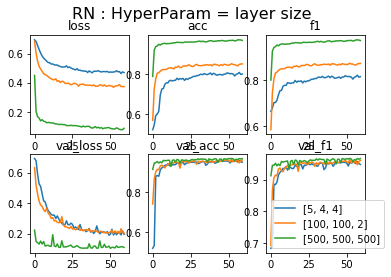

In [10]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)

leg = [str(i) for i in nb_perceptrons_range]                                                                                                                                          

titre = "RN : HyperParam = layer size"   

plot_perf(ho, leg, titre ,sub_title)

Nous remarquons qu'avec trois couches, les performances d'accuracy et de f1_score sont meilleures dans le cas de [500,500,500] (dépassant les 95%). On remarque également que la perte ("loss") est, en quelque sorte, inversement proportionnelle aux f1_score et accuracy dans ce cas. C'est-à-dire que pour un f1_score et une accuracy plus faible (nombre de perceptrons inférieur) la valeur de perte sera plus importante que les architectures avec plus de perceptrons.


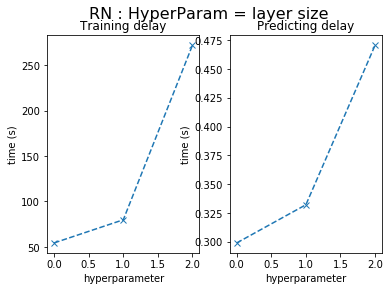

In [11]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)

En revanche, ajouter un nombre de perceptrons par couche important influence grandement le temps d'entrainement et de prédiction.


2 : Influence du nombre de couches :

In [12]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0

layer_sizes_range = [[100],[100, 100, 2],[100, 100, 100, 100, 100, 2]]

# Suppression de la dernière étude d'hyperparamètre
try:
    tf.reset_default_graph()
    shutil.rmtree('./logs')
except:
    print("nothing to delete")

# Callbacks pour affichage des performances dans tensorflow : 1 callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(3):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006
cpt = 0
for layer_s in layer_sizes_range:
    model = RN_model(layer_s, dropout, learning_rate)
    #### Apprentissage                                                                                                                                                               
    start = time.time()                                                                                                                   
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]]) 

    end = time.time()
    training_delay_RN.append(end - start)

    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                  
    start = time.time()

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)

    end = time.time()
    predicting_delay_RN.append(end - start)
    cpt+=1

nothing to delete
Train on 12800 samples, validate on 3200 samples
Epoch 1/60
12800/12800 [==============================] - 2s 138us/sample - loss: 0.6292 - acc: 0.6778 - f1: 0.6957 - val_loss: 0.5179 - val_acc: 0.8200 - val_f1: 0.8215
Epoch 2/60
12800/12800 [==============================] - 1s 57us/sample - loss: 0.4356 - acc: 0.8280 - f1: 0.8329 - val_loss: 0.3649 - val_acc: 0.8497 - val_f1: 0.8478
Epoch 3/60
12800/12800 [==============================] - 1s 58us/sample - loss: 0.3332 - acc: 0.8703 - f1: 0.8735 - val_loss: 0.2828 - val_acc: 0.8956 - val_f1: 0.8997
Epoch 4/60
12800/12800 [==============================] - 1s 56us/sample - loss: 0.2703 - acc: 0.8998 - f1: 0.9027 - val_loss: 0.2299 - val_acc: 0.9162 - val_f1: 0.9186
Epoch 5/60
12800/12800 [==============================] - 1s 56us/sample - loss: 0.2309 - acc: 0.9173 - f1: 0.9197 - val_loss: 0.1995 - val_acc: 0.9234 - val_f1: 0.9260
Epoch 6/60
12800/12800 [==============================] - 1s 56us/sample - loss: 0.2030

Epoch 49/60
12800/12800 [==============================] - 1s 56us/sample - loss: 0.1127 - acc: 0.9591 - f1: 0.9606 - val_loss: 0.1027 - val_acc: 0.9603 - val_f1: 0.9615
Epoch 50/60
12800/12800 [==============================] - 1s 56us/sample - loss: 0.1137 - acc: 0.9602 - f1: 0.9612 - val_loss: 0.1036 - val_acc: 0.9597 - val_f1: 0.9611
Epoch 51/60
12800/12800 [==============================] - 1s 55us/sample - loss: 0.1082 - acc: 0.9609 - f1: 0.9620 - val_loss: 0.1102 - val_acc: 0.9547 - val_f1: 0.9550
Epoch 52/60
12800/12800 [==============================] - 1s 55us/sample - loss: 0.1122 - acc: 0.9593 - f1: 0.9604 - val_loss: 0.1102 - val_acc: 0.9563 - val_f1: 0.9567
Epoch 53/60
12800/12800 [==============================] - 1s 63us/sample - loss: 0.1115 - acc: 0.9580 - f1: 0.9590 - val_loss: 0.1190 - val_acc: 0.9544 - val_f1: 0.9546
Epoch 54/60
12800/12800 [==============================] - 1s 59us/sample - loss: 0.1108 - acc: 0.9606 - f1: 0.9620 - val_loss: 0.1022 - val_acc: 0.96

Epoch 37/60
12800/12800 [==============================] - 1s 86us/sample - loss: 0.4105 - acc: 0.7344 - f1: 0.7905 - val_loss: 0.1642 - val_acc: 0.9550 - val_f1: 0.9551
Epoch 38/60
12800/12800 [==============================] - 1s 86us/sample - loss: 0.4069 - acc: 0.7370 - f1: 0.7931 - val_loss: 0.1586 - val_acc: 0.9553 - val_f1: 0.9553
Epoch 39/60
12800/12800 [==============================] - 1s 92us/sample - loss: 0.4133 - acc: 0.7320 - f1: 0.7900 - val_loss: 0.1588 - val_acc: 0.9550 - val_f1: 0.9580
Epoch 40/60
12800/12800 [==============================] - 1s 88us/sample - loss: 0.4054 - acc: 0.7406 - f1: 0.7959 - val_loss: 0.1537 - val_acc: 0.9600 - val_f1: 0.9606
Epoch 41/60
12800/12800 [==============================] - 1s 86us/sample - loss: 0.4045 - acc: 0.7379 - f1: 0.7929 - val_loss: 0.1492 - val_acc: 0.9588 - val_f1: 0.9599
Epoch 42/60
12800/12800 [==============================] - 1s 85us/sample - loss: 0.3998 - acc: 0.7427 - f1: 0.7969 - val_loss: 0.1483 - val_acc: 0.95

Epoch 25/60
12800/12800 [==============================] - 2s 159us/sample - loss: 0.3980 - acc: 0.8391 - f1: 0.8612 - val_loss: 0.2473 - val_acc: 0.9475 - val_f1: 0.9485
Epoch 26/60
12800/12800 [==============================] - 2s 168us/sample - loss: 0.4030 - acc: 0.8356 - f1: 0.8586 - val_loss: 0.2448 - val_acc: 0.9484 - val_f1: 0.9504
Epoch 27/60
12800/12800 [==============================] - 2s 157us/sample - loss: 0.4026 - acc: 0.8371 - f1: 0.8600 - val_loss: 0.2504 - val_acc: 0.9459 - val_f1: 0.9489
Epoch 28/60
12800/12800 [==============================] - 2s 158us/sample - loss: 0.4048 - acc: 0.8357 - f1: 0.8584 - val_loss: 0.2497 - val_acc: 0.9478 - val_f1: 0.9504
Epoch 29/60
12800/12800 [==============================] - 2s 158us/sample - loss: 0.4024 - acc: 0.8342 - f1: 0.8582 - val_loss: 0.2395 - val_acc: 0.9509 - val_f1: 0.9535
Epoch 30/60
12800/12800 [==============================] - 2s 157us/sample - loss: 0.4032 - acc: 0.8339 - f1: 0.8578 - val_loss: 0.2405 - val_acc

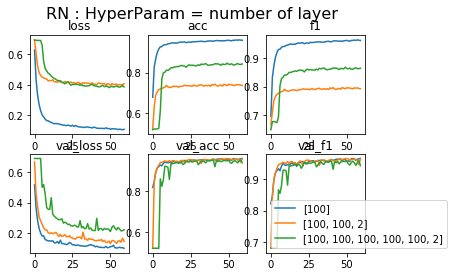

In [13]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)

leg = [str(i) for i in layer_sizes_range]                                                                                                                                              

titre = "RN : HyperParam = number of layer"                                                                                                                                         

plot_perf(ho, leg, titre ,sub_title)

Dans notre problème de classification de galaxies, on note que le les valeurs des accuracy et des f1_scores tendent vers les mêmes performances sur les jeux de données de tests qu'il y ait une, trois ou six couches (nombreb de perceptrons constant par couche). On remarque également que la valeur de perte est moins importante dans le cas où il y a le moins de couches. 


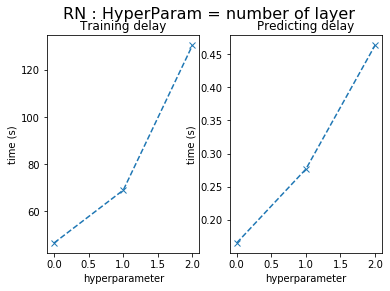

In [14]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)

Ici, nous remarquons que : plus le nombre de couches est important plus le temps d'entrainement et de prédiction sont élevés.

3 - Influence du taux d'apprentissage:

In [15]:
################################## Learning rate                                                                                                                                     
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0

l_rate_range = [0.00001,0.0005,0.01]

# Suppression de la dernière étude d'hyperparamètre
try:
    tf.reset_default_graph()
    shutil.rmtree('./logs')
except:
    print("nothing to delete")

# Callbacks pour affichage des performances dans tensorflow : 1 callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(3):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))#time.time())))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006
cpt = 0
for l_rate in l_rate_range:
    model = RN_model(layer_sizes, dropout, l_rate)
    #### Apprentissage
    start = time.time()
    #model.fit(X_train, Y_train, batch_size = 100, epochs = 60)
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]])
    end = time.time()
    training_delay_RN.append(end - start)

    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction
    start = time.time()

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)

    end = time.time()
    predicting_delay_RN.append(end - start)
    cpt+=1

nothing to delete
Train on 12800 samples, validate on 3200 samples
Epoch 1/60
12800/12800 [==============================] - 3s 252us/sample - loss: 0.7097 - acc: 0.5020 - f1: 0.5683 - val_loss: 0.6926 - val_acc: 0.5169 - val_f1: 0.6784
Epoch 2/60
12800/12800 [==============================] - 1s 87us/sample - loss: 0.7031 - acc: 0.5091 - f1: 0.6160 - val_loss: 0.6917 - val_acc: 0.5181 - val_f1: 0.6770
Epoch 3/60
12800/12800 [==============================] - 1s 87us/sample - loss: 0.7009 - acc: 0.5114 - f1: 0.6205 - val_loss: 0.6913 - val_acc: 0.5200 - val_f1: 0.6776
Epoch 4/60
12800/12800 [==============================] - 1s 93us/sample - loss: 0.6985 - acc: 0.5138 - f1: 0.6245 - val_loss: 0.6918 - val_acc: 0.5194 - val_f1: 0.6802
Epoch 5/60
12800/12800 [==============================] - 1s 92us/sample - loss: 0.6967 - acc: 0.5197 - f1: 0.6316 - val_loss: 0.6925 - val_acc: 0.5184 - val_f1: 0.6793
Epoch 6/60
12800/12800 [==============================] - 1s 91us/sample - loss: 0.6950

Epoch 49/60
12800/12800 [==============================] - 2s 120us/sample - loss: 0.6182 - acc: 0.6277 - f1: 0.6935 - val_loss: 0.5794 - val_acc: 0.8453 - val_f1: 0.8485
Epoch 50/60
12800/12800 [==============================] - 2s 130us/sample - loss: 0.6174 - acc: 0.6282 - f1: 0.6932 - val_loss: 0.5757 - val_acc: 0.8484 - val_f1: 0.8542
Epoch 51/60
12800/12800 [==============================] - 2s 144us/sample - loss: 0.6159 - acc: 0.6305 - f1: 0.6984 - val_loss: 0.5720 - val_acc: 0.8487 - val_f1: 0.8529
Epoch 52/60
12800/12800 [==============================] - 1s 101us/sample - loss: 0.6115 - acc: 0.6327 - f1: 0.6972 - val_loss: 0.5682 - val_acc: 0.8516 - val_f1: 0.8567
Epoch 53/60
12800/12800 [==============================] - 1s 87us/sample - loss: 0.6083 - acc: 0.6322 - f1: 0.6997 - val_loss: 0.5644 - val_acc: 0.8519 - val_f1: 0.8565
Epoch 54/60
12800/12800 [==============================] - 1s 87us/sample - loss: 0.6030 - acc: 0.6395 - f1: 0.7037 - val_loss: 0.5598 - val_acc: 

Epoch 37/60
12800/12800 [==============================] - 1s 88us/sample - loss: 0.3884 - acc: 0.8359 - f1: 0.8152 - val_loss: 0.2177 - val_acc: 0.9572 - val_f1: 0.9586
Epoch 38/60
12800/12800 [==============================] - 1s 96us/sample - loss: 0.3859 - acc: 0.8395 - f1: 0.8207 - val_loss: 0.2321 - val_acc: 0.9513 - val_f1: 0.9517
Epoch 39/60
12800/12800 [==============================] - 1s 86us/sample - loss: 0.3935 - acc: 0.8321 - f1: 0.8121 - val_loss: 0.2537 - val_acc: 0.9353 - val_f1: 0.9337
Epoch 40/60
12800/12800 [==============================] - 1s 83us/sample - loss: 0.3907 - acc: 0.8337 - f1: 0.8139 - val_loss: 0.2765 - val_acc: 0.9194 - val_f1: 0.9166
Epoch 41/60
12800/12800 [==============================] - 1s 83us/sample - loss: 0.3973 - acc: 0.8302 - f1: 0.8096 - val_loss: 0.2178 - val_acc: 0.9588 - val_f1: 0.9600
Epoch 42/60
12800/12800 [==============================] - 1s 85us/sample - loss: 0.3870 - acc: 0.8345 - f1: 0.8152 - val_loss: 0.2199 - val_acc: 0.95

Epoch 25/60
12800/12800 [==============================] - 1s 88us/sample - loss: 0.6925 - acc: 0.5192 - f1: 0.6817 - val_loss: 0.6931 - val_acc: 0.5191 - val_f1: 0.6825
Epoch 26/60
12800/12800 [==============================] - 1s 93us/sample - loss: 0.6927 - acc: 0.5192 - f1: 0.6821 - val_loss: 0.6925 - val_acc: 0.5191 - val_f1: 0.6809
Epoch 27/60
12800/12800 [==============================] - 1s 97us/sample - loss: 0.6925 - acc: 0.5192 - f1: 0.6822 - val_loss: 0.6925 - val_acc: 0.5191 - val_f1: 0.6825
Epoch 28/60
12800/12800 [==============================] - 2s 146us/sample - loss: 0.6925 - acc: 0.5192 - f1: 0.6822 - val_loss: 0.6925 - val_acc: 0.5191 - val_f1: 0.6819
Epoch 29/60
12800/12800 [==============================] - 1s 110us/sample - loss: 0.6927 - acc: 0.5136 - f1: 0.6539 - val_loss: 0.6925 - val_acc: 0.5191 - val_f1: 0.6816
Epoch 30/60
12800/12800 [==============================] - 1s 99us/sample - loss: 0.6925 - acc: 0.5192 - f1: 0.6821 - val_loss: 0.6925 - val_acc: 0.

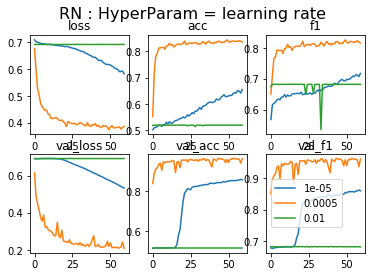

In [16]:
# Traitement pour affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)
                                                                                                                                      
leg = [str(i) for i in l_rate_range]                                                                                                                                                
                                                                                                                                    
titre = "RN : HyperParam = learning rate"                                                                                                                                           

plot_perf(ho, leg, titre ,sub_title)

Ici nous étudions l'influence du learning rate. Nous remarquons que nous devons trouver un compromis dans la valeur du learning rate pour avoir une étude dont les performances sont bonnes. Il semble que la valeur de learning rate qui optimise ces résultats se trouve à 0.0005. 

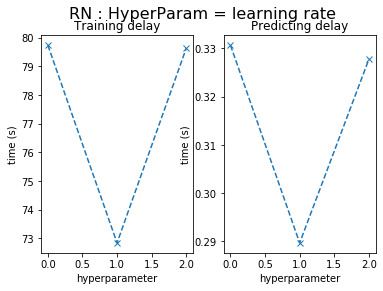

In [17]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)

Nous remarquons ici que c'est la valeur de 0.0005 qui nous apporte les meilleures performances en termes de temps bien que l'ordre de grandeur est similaire (70sec-80sec), ce qui constitue donc le meilleur compromis.

## Question 4


Ici, nous allons faire varier le nombre d'epochs. Nous allons notament visualiser le phénomène de surapprentissage en paramétrant un nombre d'epochs très grand.

In [5]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0

epochs_range = [30,60, 5000]                                                                                                                                            
max_ep = max(epochs_range) 

# Suppression de la dernière étude d'hyperparamètre
try:
    tf.reset_default_graph()
    shutil.rmtree('./logs')
except:
    print("nothing to delete")
    
# Callbacks pour affichage des performances dans tensorflow : 1 callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(3):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006
cpt = 0
for ep in epochs_range:                                                                                                                                                            
    model = RN_model(layer_sizes, dropout, learning_rate)                                                                                                                          
    #### Apprentissage                                                                                                                                                             
    start = time.time()                                                                                                                                                            
    #model.fit(X_train, Y_train, batch_size = 100, epochs = 60)                                                                                                                    
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = ep, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]])                                                                  

    end = time.time()                                                                                                                                                              
    training_delay_RN.append(end - start)                                                                                                                                          

    ho_tmp = list(hist_obj.history.values())                                                                                                                                       
    ho_tmp = [i + [np.nan for _ in range(max_ep-ep)] for i in ho_tmp ]                                                                                                             
    history_obj.append(ho_tmp)
    #### Prédiction                                                                                                                                                                
    start = time.time()                                                                                                                                                            

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)                                                                                                                           

    end = time.time()                                                                                                                                                              
    predicting_delay_RN.append(end - start) 
    cpt+=1

Train on 12800 samples, validate on 3200 samples
Epoch 1/30
12800/12800 [==============================] - 0s 35us/sample - loss: 0.6914 - acc: 0.5196 - f1: 0.5394 - val_loss: 0.6674 - val_acc: 0.6288 - val_f1: 0.7314
Epoch 2/30
12800/12800 [==============================] - 0s 16us/sample - loss: 0.6181 - acc: 0.6126 - f1: 0.6093 - val_loss: 0.4916 - val_acc: 0.8550 - val_f1: 0.8533
Epoch 3/30
12800/12800 [==============================] - 0s 16us/sample - loss: 0.5316 - acc: 0.6757 - f1: 0.5877 - val_loss: 0.3570 - val_acc: 0.9041 - val_f1: 0.9079
Epoch 4/30
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4955 - acc: 0.6856 - f1: 0.5981 - val_loss: 0.3395 - val_acc: 0.8966 - val_f1: 0.8922
Epoch 5/30
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4658 - acc: 0.6995 - f1: 0.6151 - val_loss: 0.2713 - val_acc: 0.9325 - val_f1: 0.9354
Epoch 6/30
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4485 - acc: 0.7016 - f1

Epoch 19/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3978 - acc: 0.8338 - f1: 0.8147 - val_loss: 0.2567 - val_acc: 0.9519 - val_f1: 0.9532
Epoch 20/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4058 - acc: 0.8241 - f1: 0.8023 - val_loss: 0.2704 - val_acc: 0.9378 - val_f1: 0.9363
Epoch 21/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3990 - acc: 0.8291 - f1: 0.8078 - val_loss: 0.2408 - val_acc: 0.9569 - val_f1: 0.9584
Epoch 22/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4000 - acc: 0.8280 - f1: 0.8068 - val_loss: 0.2412 - val_acc: 0.9544 - val_f1: 0.9552
Epoch 23/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3924 - acc: 0.8316 - f1: 0.8107 - val_loss: 0.2397 - val_acc: 0.9544 - val_f1: 0.9554
Epoch 24/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4002 - acc: 0.8291 - f1: 0.8078 - val_loss: 0.2452 - val_acc: 0.95

Epoch 7/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4668 - acc: 0.8155 - f1: 0.8425 - val_loss: 0.3501 - val_acc: 0.9362 - val_f1: 0.9390
Epoch 8/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4544 - acc: 0.8248 - f1: 0.8497 - val_loss: 0.3380 - val_acc: 0.9344 - val_f1: 0.9373
Epoch 9/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4514 - acc: 0.8207 - f1: 0.8469 - val_loss: 0.3306 - val_acc: 0.9362 - val_f1: 0.9384
Epoch 10/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4338 - acc: 0.8320 - f1: 0.8548 - val_loss: 0.3279 - val_acc: 0.9375 - val_f1: 0.9416
Epoch 11/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4344 - acc: 0.8300 - f1: 0.8540 - val_loss: 0.3064 - val_acc: 0.9394 - val_f1: 0.9415
Epoch 12/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4189 - acc: 0.8359 - f1: 0.8589 - val_loss: 0.3015 - val_

Epoch 55/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3771 - acc: 0.8459 - f1: 0.8675 - val_loss: 0.2483 - val_acc: 0.9353 - val_f1: 0.9407
Epoch 56/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3681 - acc: 0.8505 - f1: 0.8710 - val_loss: 0.2095 - val_acc: 0.9525 - val_f1: 0.9552
Epoch 57/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3770 - acc: 0.8467 - f1: 0.8675 - val_loss: 0.2199 - val_acc: 0.9472 - val_f1: 0.9505
Epoch 58/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3778 - acc: 0.8461 - f1: 0.8675 - val_loss: 0.2065 - val_acc: 0.9578 - val_f1: 0.9591
Epoch 59/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3802 - acc: 0.8440 - f1: 0.8660 - val_loss: 0.2077 - val_acc: 0.9572 - val_f1: 0.9580
Epoch 60/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3676 - acc: 0.8542 - f1: 0.8736 - val_loss: 0.2079 - v

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3609 - acc: 0.8530 - f1: 0.8732 - val_loss: 0.2022 - val_acc: 0.9547 - val_f1: 0.9576
Epoch 150/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3676 - acc: 0.8499 - f1: 0.8709 - val_loss: 0.2003 - val_acc: 0.9628 - val_f1: 0.9641
Epoch 151/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3573 - acc: 0.8559 - f1: 0.8760 - val_loss: 0.2017 - val_acc: 0.9547 - val_f1: 0.9566
Epoch 152/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3598 - acc: 0.8558 - f1: 0.8748 - val_loss: 0.1992 - val_acc: 0.9634 - val_f1: 0.9651
Epoch 153/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3551 - acc: 0.8569 - f1: 0.8764 - val_loss: 0.1945 - val_acc: 0.9628 - val_f1: 0.9643
Epoch 154/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3613 - acc: 0.8530 - f1: 0.8730 - val_loss: 0.1915 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3627 - acc: 0.8514 - f1: 0.8723 - val_loss: 0.2042 - val_acc: 0.9563 - val_f1: 0.9589
Epoch 244/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3547 - acc: 0.8577 - f1: 0.8769 - val_loss: 0.1992 - val_acc: 0.9613 - val_f1: 0.9639
Epoch 245/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3460 - acc: 0.8609 - f1: 0.8797 - val_loss: 0.2264 - val_acc: 0.9422 - val_f1: 0.9460
Epoch 246/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3501 - acc: 0.8594 - f1: 0.8785 - val_loss: 0.1938 - val_acc: 0.9653 - val_f1: 0.9667
Epoch 247/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3482 - acc: 0.8616 - f1: 0.8795 - val_loss: 0.1965 - val_acc: 0.9650 - val_f1: 0.9659
Epoch 248/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3535 - acc: 0.8582 - f1: 0.8774 - val_loss: 0.2144 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3594 - acc: 0.8540 - f1: 0.8741 - val_loss: 0.2015 - val_acc: 0.9619 - val_f1: 0.9639
Epoch 338/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3537 - acc: 0.8590 - f1: 0.8787 - val_loss: 0.1952 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 339/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3483 - acc: 0.8598 - f1: 0.8787 - val_loss: 0.2082 - val_acc: 0.9644 - val_f1: 0.9654
Epoch 340/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3452 - acc: 0.8619 - f1: 0.8802 - val_loss: 0.2034 - val_acc: 0.9631 - val_f1: 0.9644
Epoch 341/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3522 - acc: 0.8548 - f1: 0.8751 - val_loss: 0.2038 - val_acc: 0.9619 - val_f1: 0.9634
Epoch 342/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3390 - acc: 0.8651 - f1: 0.8831 - val_loss: 0.1966 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3483 - acc: 0.8589 - f1: 0.8786 - val_loss: 0.1964 - val_acc: 0.9641 - val_f1: 0.9652
Epoch 432/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3432 - acc: 0.8623 - f1: 0.8805 - val_loss: 0.2115 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 433/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3513 - acc: 0.8579 - f1: 0.8771 - val_loss: 0.2042 - val_acc: 0.9634 - val_f1: 0.9652
Epoch 434/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3441 - acc: 0.8627 - f1: 0.8808 - val_loss: 0.2059 - val_acc: 0.9641 - val_f1: 0.9653
Epoch 435/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3513 - acc: 0.8587 - f1: 0.8776 - val_loss: 0.2047 - val_acc: 0.9622 - val_f1: 0.9638
Epoch 436/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3515 - acc: 0.8580 - f1: 0.8772 - val_loss: 0.2024 - val_acc: 0

12800/12800 [==============================] - 0s 16us/sample - loss: 0.3492 - acc: 0.8598 - f1: 0.8789 - val_loss: 0.2025 - val_acc: 0.9656 - val_f1: 0.9670
Epoch 526/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3598 - acc: 0.8547 - f1: 0.8747 - val_loss: 0.2074 - val_acc: 0.9641 - val_f1: 0.9657
Epoch 527/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3442 - acc: 0.8622 - f1: 0.8811 - val_loss: 0.2019 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 528/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3432 - acc: 0.8630 - f1: 0.8817 - val_loss: 0.2049 - val_acc: 0.9669 - val_f1: 0.9680
Epoch 529/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3437 - acc: 0.8624 - f1: 0.8813 - val_loss: 0.2188 - val_acc: 0.9506 - val_f1: 0.9535
Epoch 530/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3442 - acc: 0.8618 - f1: 0.8807 - val_loss: 0.2052 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3417 - acc: 0.8636 - f1: 0.8821 - val_loss: 0.2054 - val_acc: 0.9584 - val_f1: 0.9605
Epoch 620/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3475 - acc: 0.8599 - f1: 0.8795 - val_loss: 0.2136 - val_acc: 0.9581 - val_f1: 0.9607
Epoch 621/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3454 - acc: 0.8612 - f1: 0.8800 - val_loss: 0.2098 - val_acc: 0.9631 - val_f1: 0.9644
Epoch 622/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3390 - acc: 0.8650 - f1: 0.8830 - val_loss: 0.2060 - val_acc: 0.9656 - val_f1: 0.9669
Epoch 623/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3469 - acc: 0.8598 - f1: 0.8791 - val_loss: 0.2014 - val_acc: 0.9653 - val_f1: 0.9668
Epoch 624/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3376 - acc: 0.8655 - f1: 0.8835 - val_loss: 0.2140 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3423 - acc: 0.8632 - f1: 0.8812 - val_loss: 0.2132 - val_acc: 0.9603 - val_f1: 0.9619
Epoch 714/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3382 - acc: 0.8645 - f1: 0.8829 - val_loss: 0.2092 - val_acc: 0.9663 - val_f1: 0.9677
Epoch 715/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3427 - acc: 0.8612 - f1: 0.8800 - val_loss: 0.2099 - val_acc: 0.9578 - val_f1: 0.9607
Epoch 716/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3488 - acc: 0.8598 - f1: 0.8794 - val_loss: 0.2114 - val_acc: 0.9600 - val_f1: 0.9622
Epoch 717/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3441 - acc: 0.8616 - f1: 0.8807 - val_loss: 0.2126 - val_acc: 0.9616 - val_f1: 0.9631
Epoch 718/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3468 - acc: 0.8594 - f1: 0.8787 - val_loss: 0.2161 - val_acc: 0

Epoch 760/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3415 - acc: 0.8642 - f1: 0.8824 - val_loss: 0.2088 - val_acc: 0.9619 - val_f1: 0.9638
Epoch 761/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3380 - acc: 0.8659 - f1: 0.8840 - val_loss: 0.2097 - val_acc: 0.9631 - val_f1: 0.9646
Epoch 762/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3370 - acc: 0.8660 - f1: 0.8841 - val_loss: 0.2050 - val_acc: 0.9638 - val_f1: 0.9654
Epoch 763/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3415 - acc: 0.8625 - f1: 0.8814 - val_loss: 0.2122 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 764/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3384 - acc: 0.8647 - f1: 0.8832 - val_loss: 0.2053 - val_acc: 0.9650 - val_f1: 0.9664
Epoch 765/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3384 - acc: 0.8645 - f1: 0.8829 - val_loss: 0.20

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3477 - acc: 0.8590 - f1: 0.8788 - val_loss: 0.2070 - val_acc: 0.9644 - val_f1: 0.9654
Epoch 808/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3416 - acc: 0.8630 - f1: 0.8817 - val_loss: 0.2040 - val_acc: 0.9672 - val_f1: 0.9691
Epoch 809/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3408 - acc: 0.8627 - f1: 0.8813 - val_loss: 0.2304 - val_acc: 0.9616 - val_f1: 0.9626
Epoch 810/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3375 - acc: 0.8659 - f1: 0.8838 - val_loss: 0.2091 - val_acc: 0.9609 - val_f1: 0.9625
Epoch 811/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3382 - acc: 0.8640 - f1: 0.8822 - val_loss: 0.2075 - val_acc: 0.9641 - val_f1: 0.9655
Epoch 812/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3390 - acc: 0.8655 - f1: 0.8831 - val_loss: 0.2062 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3448 - acc: 0.8607 - f1: 0.8799 - val_loss: 0.2154 - val_acc: 0.9669 - val_f1: 0.9683
Epoch 902/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3382 - acc: 0.8652 - f1: 0.8833 - val_loss: 0.2099 - val_acc: 0.9666 - val_f1: 0.9678
Epoch 903/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3315 - acc: 0.8680 - f1: 0.8858 - val_loss: 0.2529 - val_acc: 0.9613 - val_f1: 0.9617
Epoch 904/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3361 - acc: 0.8667 - f1: 0.8842 - val_loss: 0.2133 - val_acc: 0.9659 - val_f1: 0.9670
Epoch 905/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3440 - acc: 0.8637 - f1: 0.8818 - val_loss: 0.2169 - val_acc: 0.9650 - val_f1: 0.9652
Epoch 906/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3362 - acc: 0.8645 - f1: 0.8829 - val_loss: 0.2198 - val_acc: 0

12800/12800 [==============================] - 0s 16us/sample - loss: 0.3374 - acc: 0.8645 - f1: 0.8834 - val_loss: 0.2136 - val_acc: 0.9659 - val_f1: 0.9671
Epoch 996/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3429 - acc: 0.8616 - f1: 0.8808 - val_loss: 0.2107 - val_acc: 0.9659 - val_f1: 0.9679
Epoch 997/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3310 - acc: 0.8673 - f1: 0.8848 - val_loss: 0.2336 - val_acc: 0.9675 - val_f1: 0.9686
Epoch 998/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3408 - acc: 0.8641 - f1: 0.8826 - val_loss: 0.2525 - val_acc: 0.9522 - val_f1: 0.9533
Epoch 999/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3489 - acc: 0.8580 - f1: 0.8781 - val_loss: 0.2206 - val_acc: 0.9653 - val_f1: 0.9667
Epoch 1000/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3279 - acc: 0.8713 - f1: 0.8882 - val_loss: 0.2112 - val_acc: 

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3405 - acc: 0.8632 - f1: 0.8819 - val_loss: 0.2302 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 1090/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3339 - acc: 0.8660 - f1: 0.8842 - val_loss: 0.2252 - val_acc: 0.9653 - val_f1: 0.9669
Epoch 1091/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3376 - acc: 0.8646 - f1: 0.8833 - val_loss: 0.2329 - val_acc: 0.9622 - val_f1: 0.9633
Epoch 1092/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3464 - acc: 0.8599 - f1: 0.8794 - val_loss: 0.2165 - val_acc: 0.9609 - val_f1: 0.9624
Epoch 1093/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3398 - acc: 0.8634 - f1: 0.8819 - val_loss: 0.2128 - val_acc: 0.9597 - val_f1: 0.9617
Epoch 1094/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3297 - acc: 0.8686 - f1: 0.8864 - val_loss: 0.2141 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3421 - acc: 0.8620 - f1: 0.8807 - val_loss: 0.2178 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 1184/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3320 - acc: 0.8677 - f1: 0.8852 - val_loss: 0.2361 - val_acc: 0.9653 - val_f1: 0.9662
Epoch 1185/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3249 - acc: 0.8728 - f1: 0.8893 - val_loss: 0.2366 - val_acc: 0.9394 - val_f1: 0.9437
Epoch 1186/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3496 - acc: 0.8601 - f1: 0.8791 - val_loss: 0.2057 - val_acc: 0.9638 - val_f1: 0.9656
Epoch 1187/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3437 - acc: 0.8620 - f1: 0.8809 - val_loss: 0.2121 - val_acc: 0.9584 - val_f1: 0.9605
Epoch 1188/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3383 - acc: 0.8649 - f1: 0.8831 - val_loss: 0.2154 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3312 - acc: 0.8680 - f1: 0.8858 - val_loss: 0.2158 - val_acc: 0.9653 - val_f1: 0.9668
Epoch 1278/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3393 - acc: 0.8639 - f1: 0.8824 - val_loss: 0.2336 - val_acc: 0.9641 - val_f1: 0.9648
Epoch 1279/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3412 - acc: 0.8639 - f1: 0.8820 - val_loss: 0.2163 - val_acc: 0.9581 - val_f1: 0.9608
Epoch 1280/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3307 - acc: 0.8694 - f1: 0.8863 - val_loss: 0.2039 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 1281/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3370 - acc: 0.8648 - f1: 0.8836 - val_loss: 0.2183 - val_acc: 0.9653 - val_f1: 0.9671
Epoch 1282/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3396 - acc: 0.8635 - f1: 0.8825 - val_loss: 0.2298 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3313 - acc: 0.8686 - f1: 0.8861 - val_loss: 0.2209 - val_acc: 0.9572 - val_f1: 0.9589
Epoch 1372/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3320 - acc: 0.8681 - f1: 0.8858 - val_loss: 0.2198 - val_acc: 0.9622 - val_f1: 0.9639
Epoch 1373/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3384 - acc: 0.8645 - f1: 0.8830 - val_loss: 0.2141 - val_acc: 0.9594 - val_f1: 0.9619
Epoch 1374/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3340 - acc: 0.8670 - f1: 0.8854 - val_loss: 0.2241 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 1375/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3380 - acc: 0.8656 - f1: 0.8842 - val_loss: 0.2109 - val_acc: 0.9594 - val_f1: 0.9613
Epoch 1376/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3353 - acc: 0.8671 - f1: 0.8848 - val_loss: 0.2282 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3336 - acc: 0.8669 - f1: 0.8849 - val_loss: 0.2183 - val_acc: 0.9669 - val_f1: 0.9685
Epoch 1466/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3393 - acc: 0.8655 - f1: 0.8834 - val_loss: 0.2232 - val_acc: 0.9663 - val_f1: 0.9670
Epoch 1467/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3380 - acc: 0.8641 - f1: 0.8831 - val_loss: 0.2172 - val_acc: 0.9681 - val_f1: 0.9695
Epoch 1468/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3315 - acc: 0.8683 - f1: 0.8858 - val_loss: 0.2299 - val_acc: 0.9638 - val_f1: 0.9656
Epoch 1469/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3368 - acc: 0.8648 - f1: 0.8835 - val_loss: 0.2143 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 1470/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3283 - acc: 0.8708 - f1: 0.8879 - val_loss: 0.2248 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3361 - acc: 0.8659 - f1: 0.8841 - val_loss: 0.2175 - val_acc: 0.9594 - val_f1: 0.9615
Epoch 1560/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3486 - acc: 0.8585 - f1: 0.8783 - val_loss: 0.2077 - val_acc: 0.9628 - val_f1: 0.9649
Epoch 1561/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3353 - acc: 0.8672 - f1: 0.8854 - val_loss: 0.2395 - val_acc: 0.9656 - val_f1: 0.9666
Epoch 1562/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3308 - acc: 0.8694 - f1: 0.8864 - val_loss: 0.2416 - val_acc: 0.9638 - val_f1: 0.9642
Epoch 1563/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3321 - acc: 0.8677 - f1: 0.8860 - val_loss: 0.2112 - val_acc: 0.9669 - val_f1: 0.9685
Epoch 1564/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3314 - acc: 0.8673 - f1: 0.8856 - val_loss: 0.2387 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3340 - acc: 0.8659 - f1: 0.8839 - val_loss: 0.2224 - val_acc: 0.9628 - val_f1: 0.9648
Epoch 1654/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3456 - acc: 0.8613 - f1: 0.8807 - val_loss: 0.2118 - val_acc: 0.9656 - val_f1: 0.9672
Epoch 1655/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3267 - acc: 0.8717 - f1: 0.8885 - val_loss: 0.2268 - val_acc: 0.9675 - val_f1: 0.9690
Epoch 1656/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3412 - acc: 0.8631 - f1: 0.8820 - val_loss: 0.2256 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 1657/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3304 - acc: 0.8687 - f1: 0.8864 - val_loss: 0.2236 - val_acc: 0.9656 - val_f1: 0.9674
Epoch 1658/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3364 - acc: 0.8662 - f1: 0.8848 - val_loss: 0.2204 - val_a

Epoch 1747/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3386 - acc: 0.8640 - f1: 0.8827 - val_loss: 0.2190 - val_acc: 0.9641 - val_f1: 0.9654
Epoch 1748/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3300 - acc: 0.8694 - f1: 0.8868 - val_loss: 0.2366 - val_acc: 0.9603 - val_f1: 0.9619
Epoch 1749/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3320 - acc: 0.8676 - f1: 0.8855 - val_loss: 0.2214 - val_acc: 0.9669 - val_f1: 0.9675
Epoch 1750/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3397 - acc: 0.8631 - f1: 0.8824 - val_loss: 0.2145 - val_acc: 0.9656 - val_f1: 0.9674
Epoch 1751/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3422 - acc: 0.8627 - f1: 0.8814 - val_loss: 0.2580 - val_acc: 0.9638 - val_f1: 0.9647
Epoch 1752/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3276 - acc: 0.8723 - f1: 0.8888 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3326 - acc: 0.8679 - f1: 0.8853 - val_loss: 0.2136 - val_acc: 0.9644 - val_f1: 0.9657
Epoch 1795/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8682 - f1: 0.8861 - val_loss: 0.2301 - val_acc: 0.9672 - val_f1: 0.9683
Epoch 1796/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3348 - acc: 0.8662 - f1: 0.8843 - val_loss: 0.2234 - val_acc: 0.9619 - val_f1: 0.9628
Epoch 1797/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3276 - acc: 0.8709 - f1: 0.8881 - val_loss: 0.2291 - val_acc: 0.9675 - val_f1: 0.9681
Epoch 1798/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3235 - acc: 0.8725 - f1: 0.8891 - val_loss: 0.2343 - val_acc: 0.9666 - val_f1: 0.9678
Epoch 1799/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3305 - acc: 0.8678 - f1: 0.8857 - val_loss: 0.2192 - val_a

Epoch 1888/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3336 - acc: 0.8677 - f1: 0.8856 - val_loss: 0.2498 - val_acc: 0.9616 - val_f1: 0.9624
Epoch 1889/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3353 - acc: 0.8662 - f1: 0.8847 - val_loss: 0.2320 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 1890/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3261 - acc: 0.8716 - f1: 0.8888 - val_loss: 0.2290 - val_acc: 0.9650 - val_f1: 0.9664
Epoch 1891/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3357 - acc: 0.8659 - f1: 0.8844 - val_loss: 0.2467 - val_acc: 0.9663 - val_f1: 0.9670
Epoch 1892/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3329 - acc: 0.8676 - f1: 0.8854 - val_loss: 0.2222 - val_acc: 0.9688 - val_f1: 0.9699
Epoch 1893/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3313 - acc: 0.8673 - f1: 0.8849 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3334 - acc: 0.8667 - f1: 0.8847 - val_loss: 0.2241 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 1936/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3341 - acc: 0.8680 - f1: 0.8858 - val_loss: 0.2220 - val_acc: 0.9616 - val_f1: 0.9632
Epoch 1937/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3284 - acc: 0.8720 - f1: 0.8887 - val_loss: 0.2213 - val_acc: 0.9669 - val_f1: 0.9678
Epoch 1938/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3225 - acc: 0.8736 - f1: 0.8903 - val_loss: 0.2243 - val_acc: 0.9650 - val_f1: 0.9669
Epoch 1939/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3383 - acc: 0.8641 - f1: 0.8825 - val_loss: 0.2199 - val_acc: 0.9647 - val_f1: 0.9655
Epoch 1940/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8694 - f1: 0.8870 - val_loss: 0.2167 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3377 - acc: 0.8647 - f1: 0.8835 - val_loss: 0.2374 - val_acc: 0.9653 - val_f1: 0.9663
Epoch 2030/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3393 - acc: 0.8647 - f1: 0.8834 - val_loss: 0.2297 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 2031/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3401 - acc: 0.8648 - f1: 0.8833 - val_loss: 0.2173 - val_acc: 0.9634 - val_f1: 0.9649
Epoch 2032/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3219 - acc: 0.8746 - f1: 0.8910 - val_loss: 0.2166 - val_acc: 0.9644 - val_f1: 0.9661
Epoch 2033/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3250 - acc: 0.8714 - f1: 0.8887 - val_loss: 0.2293 - val_acc: 0.9653 - val_f1: 0.9666
Epoch 2034/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3160 - acc: 0.8775 - f1: 0.8932 - val_loss: 0.2545 - val_a

Epoch 2076/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3251 - acc: 0.8715 - f1: 0.8880 - val_loss: 0.2219 - val_acc: 0.9650 - val_f1: 0.9664
Epoch 2077/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3320 - acc: 0.8680 - f1: 0.8861 - val_loss: 0.2246 - val_acc: 0.9650 - val_f1: 0.9660
Epoch 2078/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3330 - acc: 0.8673 - f1: 0.8850 - val_loss: 0.2230 - val_acc: 0.9666 - val_f1: 0.9675
Epoch 2079/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3301 - acc: 0.8687 - f1: 0.8867 - val_loss: 0.2268 - val_acc: 0.9678 - val_f1: 0.9690
Epoch 2080/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3258 - acc: 0.8711 - f1: 0.8886 - val_loss: 0.2286 - val_acc: 0.9663 - val_f1: 0.9677
Epoch 2081/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8686 - f1: 0.8865 - val_loss

Epoch 2123/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3319 - acc: 0.8667 - f1: 0.8847 - val_loss: 0.2575 - val_acc: 0.9647 - val_f1: 0.9658
Epoch 2124/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3417 - acc: 0.8639 - f1: 0.8828 - val_loss: 0.2187 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 2125/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3275 - acc: 0.8705 - f1: 0.8879 - val_loss: 0.2218 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 2126/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3332 - acc: 0.8666 - f1: 0.8850 - val_loss: 0.2306 - val_acc: 0.9625 - val_f1: 0.9637
Epoch 2127/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3337 - acc: 0.8655 - f1: 0.8838 - val_loss: 0.2328 - val_acc: 0.9600 - val_f1: 0.9618
Epoch 2128/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3473 - acc: 0.8612 - f1: 0.8805 - val_loss

Epoch 2170/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3298 - acc: 0.8676 - f1: 0.8854 - val_loss: 0.2279 - val_acc: 0.9647 - val_f1: 0.9655
Epoch 2171/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3165 - acc: 0.8767 - f1: 0.8927 - val_loss: 0.2359 - val_acc: 0.9663 - val_f1: 0.9674
Epoch 2172/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3333 - acc: 0.8667 - f1: 0.8851 - val_loss: 0.2320 - val_acc: 0.9631 - val_f1: 0.9645
Epoch 2173/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3265 - acc: 0.8722 - f1: 0.8891 - val_loss: 0.2422 - val_acc: 0.9694 - val_f1: 0.9704
Epoch 2174/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3273 - acc: 0.8692 - f1: 0.8868 - val_loss: 0.2309 - val_acc: 0.9619 - val_f1: 0.9635
Epoch 2175/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3291 - acc: 0.8688 - f1: 0.8861 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8695 - f1: 0.8870 - val_loss: 0.2239 - val_acc: 0.9647 - val_f1: 0.9660
Epoch 2218/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3280 - acc: 0.8714 - f1: 0.8881 - val_loss: 0.2530 - val_acc: 0.9653 - val_f1: 0.9666
Epoch 2219/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3333 - acc: 0.8673 - f1: 0.8853 - val_loss: 0.2181 - val_acc: 0.9666 - val_f1: 0.9676
Epoch 2220/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3377 - acc: 0.8640 - f1: 0.8828 - val_loss: 0.2182 - val_acc: 0.9628 - val_f1: 0.9640
Epoch 2221/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3386 - acc: 0.8641 - f1: 0.8828 - val_loss: 0.2200 - val_acc: 0.9625 - val_f1: 0.9641
Epoch 2222/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3320 - acc: 0.8670 - f1: 0.8847 - val_loss: 0.2411 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3395 - acc: 0.8630 - f1: 0.8819 - val_loss: 0.2150 - val_acc: 0.9641 - val_f1: 0.9650
Epoch 2312/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3245 - acc: 0.8723 - f1: 0.8889 - val_loss: 0.2598 - val_acc: 0.9631 - val_f1: 0.9643
Epoch 2313/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3248 - acc: 0.8712 - f1: 0.8886 - val_loss: 0.2259 - val_acc: 0.9619 - val_f1: 0.9638
Epoch 2314/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3321 - acc: 0.8670 - f1: 0.8853 - val_loss: 0.2287 - val_acc: 0.9653 - val_f1: 0.9667
Epoch 2315/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3382 - acc: 0.8645 - f1: 0.8831 - val_loss: 0.2204 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 2316/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3352 - acc: 0.8666 - f1: 0.8844 - val_loss: 0.2365 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3210 - acc: 0.8737 - f1: 0.8901 - val_loss: 0.2259 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 2406/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3316 - acc: 0.8677 - f1: 0.8855 - val_loss: 0.2300 - val_acc: 0.9609 - val_f1: 0.9630
Epoch 2407/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3266 - acc: 0.8714 - f1: 0.8884 - val_loss: 0.2496 - val_acc: 0.9644 - val_f1: 0.9652
Epoch 2408/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3258 - acc: 0.8712 - f1: 0.8883 - val_loss: 0.2285 - val_acc: 0.9647 - val_f1: 0.9658
Epoch 2409/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3288 - acc: 0.8702 - f1: 0.8877 - val_loss: 0.2459 - val_acc: 0.9644 - val_f1: 0.9652
Epoch 2410/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3283 - acc: 0.8687 - f1: 0.8869 - val_loss: 0.2270 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3355 - acc: 0.8665 - f1: 0.8848 - val_loss: 0.2169 - val_acc: 0.9619 - val_f1: 0.9642
Epoch 2500/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3342 - acc: 0.8680 - f1: 0.8863 - val_loss: 0.2415 - val_acc: 0.9656 - val_f1: 0.9669
Epoch 2501/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3242 - acc: 0.8727 - f1: 0.8897 - val_loss: 0.2130 - val_acc: 0.9653 - val_f1: 0.9671
Epoch 2502/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3366 - acc: 0.8642 - f1: 0.8829 - val_loss: 0.2279 - val_acc: 0.9638 - val_f1: 0.9654
Epoch 2503/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3261 - acc: 0.8715 - f1: 0.8885 - val_loss: 0.2311 - val_acc: 0.9656 - val_f1: 0.9670
Epoch 2504/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3319 - acc: 0.8666 - f1: 0.8845 - val_loss: 0.2351 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3264 - acc: 0.8723 - f1: 0.8886 - val_loss: 0.2276 - val_acc: 0.9650 - val_f1: 0.9660
Epoch 2594/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3235 - acc: 0.8730 - f1: 0.8899 - val_loss: 0.2243 - val_acc: 0.9647 - val_f1: 0.9662
Epoch 2595/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3255 - acc: 0.8719 - f1: 0.8884 - val_loss: 0.2378 - val_acc: 0.9634 - val_f1: 0.9645
Epoch 2596/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3299 - acc: 0.8696 - f1: 0.8869 - val_loss: 0.2260 - val_acc: 0.9672 - val_f1: 0.9677
Epoch 2597/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3284 - acc: 0.8691 - f1: 0.8868 - val_loss: 0.2398 - val_acc: 0.9650 - val_f1: 0.9664
Epoch 2598/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3199 - acc: 0.8752 - f1: 0.8918 - val_loss: 0.2572 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8689 - f1: 0.8863 - val_loss: 0.2531 - val_acc: 0.9659 - val_f1: 0.9667
Epoch 2688/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3215 - acc: 0.8730 - f1: 0.8898 - val_loss: 0.2293 - val_acc: 0.9672 - val_f1: 0.9686
Epoch 2689/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3261 - acc: 0.8710 - f1: 0.8883 - val_loss: 0.2184 - val_acc: 0.9616 - val_f1: 0.9637
Epoch 2690/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3313 - acc: 0.8683 - f1: 0.8864 - val_loss: 0.2368 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 2691/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3274 - acc: 0.8694 - f1: 0.8874 - val_loss: 0.2384 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 2692/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3262 - acc: 0.8709 - f1: 0.8884 - val_loss: 0.2394 - val_a

Epoch 2734/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3170 - acc: 0.8766 - f1: 0.8923 - val_loss: 0.2609 - val_acc: 0.9650 - val_f1: 0.9658
Epoch 2735/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3259 - acc: 0.8709 - f1: 0.8882 - val_loss: 0.2309 - val_acc: 0.9675 - val_f1: 0.9685
Epoch 2736/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3242 - acc: 0.8723 - f1: 0.8886 - val_loss: 0.2255 - val_acc: 0.9591 - val_f1: 0.9612
Epoch 2737/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3406 - acc: 0.8643 - f1: 0.8832 - val_loss: 0.2193 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 2738/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3367 - acc: 0.8649 - f1: 0.8836 - val_loss: 0.2478 - val_acc: 0.9669 - val_f1: 0.9682
Epoch 2739/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3255 - acc: 0.8719 - f1: 0.8887 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3328 - acc: 0.8673 - f1: 0.8847 - val_loss: 0.2284 - val_acc: 0.9644 - val_f1: 0.9652
Epoch 2782/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3288 - acc: 0.8698 - f1: 0.8872 - val_loss: 0.2271 - val_acc: 0.9581 - val_f1: 0.9601
Epoch 2783/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3242 - acc: 0.8722 - f1: 0.8892 - val_loss: 0.2650 - val_acc: 0.9634 - val_f1: 0.9644
Epoch 2784/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3228 - acc: 0.8745 - f1: 0.8912 - val_loss: 0.2611 - val_acc: 0.9631 - val_f1: 0.9642
Epoch 2785/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3329 - acc: 0.8682 - f1: 0.8858 - val_loss: 0.2269 - val_acc: 0.9578 - val_f1: 0.9599
Epoch 2786/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3345 - acc: 0.8666 - f1: 0.8850 - val_loss: 0.2258 - val_a

12800/12800 [==============================] - 0s 16us/sample - loss: 0.3265 - acc: 0.8705 - f1: 0.8877 - val_loss: 0.2261 - val_acc: 0.9634 - val_f1: 0.9650
Epoch 2876/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3343 - acc: 0.8670 - f1: 0.8852 - val_loss: 0.2485 - val_acc: 0.9647 - val_f1: 0.9657
Epoch 2877/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3326 - acc: 0.8682 - f1: 0.8860 - val_loss: 0.2329 - val_acc: 0.9634 - val_f1: 0.9648
Epoch 2878/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3422 - acc: 0.8618 - f1: 0.8808 - val_loss: 0.2188 - val_acc: 0.9569 - val_f1: 0.9590
Epoch 2879/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3289 - acc: 0.8692 - f1: 0.8872 - val_loss: 0.2458 - val_acc: 0.9653 - val_f1: 0.9663
Epoch 2880/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3274 - acc: 0.8706 - f1: 0.8883 - val_loss: 0.2534 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3281 - acc: 0.8702 - f1: 0.8876 - val_loss: 0.2427 - val_acc: 0.9531 - val_f1: 0.9555
Epoch 2970/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3393 - acc: 0.8650 - f1: 0.8836 - val_loss: 0.2331 - val_acc: 0.9631 - val_f1: 0.9638
Epoch 2971/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3336 - acc: 0.8678 - f1: 0.8855 - val_loss: 0.2598 - val_acc: 0.9666 - val_f1: 0.9672
Epoch 2972/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3275 - acc: 0.8709 - f1: 0.8882 - val_loss: 0.2481 - val_acc: 0.9631 - val_f1: 0.9639
Epoch 2973/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3273 - acc: 0.8711 - f1: 0.8886 - val_loss: 0.2511 - val_acc: 0.9650 - val_f1: 0.9665
Epoch 2974/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3267 - acc: 0.8703 - f1: 0.8879 - val_loss: 0.2635 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3368 - acc: 0.8662 - f1: 0.8841 - val_loss: 0.2439 - val_acc: 0.9656 - val_f1: 0.9666
Epoch 3064/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3173 - acc: 0.8755 - f1: 0.8917 - val_loss: 0.2410 - val_acc: 0.9675 - val_f1: 0.9685
Epoch 3065/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3253 - acc: 0.8713 - f1: 0.8883 - val_loss: 0.2338 - val_acc: 0.9622 - val_f1: 0.9635
Epoch 3066/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3257 - acc: 0.8727 - f1: 0.8896 - val_loss: 0.2386 - val_acc: 0.9663 - val_f1: 0.9672
Epoch 3067/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3298 - acc: 0.8693 - f1: 0.8870 - val_loss: 0.2417 - val_acc: 0.9656 - val_f1: 0.9666
Epoch 3068/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3262 - acc: 0.8705 - f1: 0.8877 - val_loss: 0.2412 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3281 - acc: 0.8709 - f1: 0.8883 - val_loss: 0.2291 - val_acc: 0.9669 - val_f1: 0.9678
Epoch 3158/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3208 - acc: 0.8734 - f1: 0.8903 - val_loss: 0.2573 - val_acc: 0.9669 - val_f1: 0.9681
Epoch 3159/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3203 - acc: 0.8740 - f1: 0.8910 - val_loss: 0.2742 - val_acc: 0.9613 - val_f1: 0.9622
Epoch 3160/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3395 - acc: 0.8652 - f1: 0.8831 - val_loss: 0.2449 - val_acc: 0.9663 - val_f1: 0.9674
Epoch 3161/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3291 - acc: 0.8690 - f1: 0.8864 - val_loss: 0.2393 - val_acc: 0.9650 - val_f1: 0.9662
Epoch 3162/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3193 - acc: 0.8744 - f1: 0.8909 - val_loss: 0.2656 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3288 - acc: 0.8691 - f1: 0.8871 - val_loss: 0.2364 - val_acc: 0.9688 - val_f1: 0.9696
Epoch 3252/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3292 - acc: 0.8685 - f1: 0.8857 - val_loss: 0.2288 - val_acc: 0.9616 - val_f1: 0.9632
Epoch 3253/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3210 - acc: 0.8736 - f1: 0.8903 - val_loss: 0.2406 - val_acc: 0.9641 - val_f1: 0.9652
Epoch 3254/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3264 - acc: 0.8710 - f1: 0.8885 - val_loss: 0.2401 - val_acc: 0.9622 - val_f1: 0.9631
Epoch 3255/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3372 - acc: 0.8648 - f1: 0.8832 - val_loss: 0.2280 - val_acc: 0.9606 - val_f1: 0.9622
Epoch 3256/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3261 - acc: 0.8715 - f1: 0.8883 - val_loss: 0.2755 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3304 - acc: 0.8683 - f1: 0.8861 - val_loss: 0.2356 - val_acc: 0.9619 - val_f1: 0.9639
Epoch 3346/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3196 - acc: 0.8749 - f1: 0.8910 - val_loss: 0.2380 - val_acc: 0.9656 - val_f1: 0.9667
Epoch 3347/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3276 - acc: 0.8697 - f1: 0.8876 - val_loss: 0.2371 - val_acc: 0.9659 - val_f1: 0.9672
Epoch 3348/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3203 - acc: 0.8747 - f1: 0.8915 - val_loss: 0.2381 - val_acc: 0.9669 - val_f1: 0.9683
Epoch 3349/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3209 - acc: 0.8747 - f1: 0.8914 - val_loss: 0.2493 - val_acc: 0.9600 - val_f1: 0.9612
Epoch 3350/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3295 - acc: 0.8689 - f1: 0.8865 - val_loss: 0.2371 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3289 - acc: 0.8691 - f1: 0.8870 - val_loss: 0.2391 - val_acc: 0.9678 - val_f1: 0.9680
Epoch 3440/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3340 - acc: 0.8659 - f1: 0.8838 - val_loss: 0.2671 - val_acc: 0.9688 - val_f1: 0.9693
Epoch 3441/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3273 - acc: 0.8698 - f1: 0.8874 - val_loss: 0.2397 - val_acc: 0.9609 - val_f1: 0.9629
Epoch 3442/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3274 - acc: 0.8709 - f1: 0.8888 - val_loss: 0.2370 - val_acc: 0.9650 - val_f1: 0.9666
Epoch 3443/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3225 - acc: 0.8727 - f1: 0.8897 - val_loss: 0.2593 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 3444/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3272 - acc: 0.8696 - f1: 0.8865 - val_loss: 0.2300 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3170 - acc: 0.8763 - f1: 0.8920 - val_loss: 0.2612 - val_acc: 0.9650 - val_f1: 0.9661
Epoch 3534/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3247 - acc: 0.8720 - f1: 0.8890 - val_loss: 0.2521 - val_acc: 0.9653 - val_f1: 0.9663
Epoch 3535/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3246 - acc: 0.8721 - f1: 0.8895 - val_loss: 0.2406 - val_acc: 0.9641 - val_f1: 0.9659
Epoch 3536/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3132 - acc: 0.8782 - f1: 0.8941 - val_loss: 0.2580 - val_acc: 0.9656 - val_f1: 0.9663
Epoch 3537/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3188 - acc: 0.8745 - f1: 0.8906 - val_loss: 0.2581 - val_acc: 0.9641 - val_f1: 0.9654
Epoch 3538/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3263 - acc: 0.8716 - f1: 0.8882 - val_loss: 0.2382 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3174 - acc: 0.8759 - f1: 0.8920 - val_loss: 0.2446 - val_acc: 0.9666 - val_f1: 0.9679
Epoch 3628/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3253 - acc: 0.8707 - f1: 0.8882 - val_loss: 0.2604 - val_acc: 0.9647 - val_f1: 0.9656
Epoch 3629/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3259 - acc: 0.8707 - f1: 0.8877 - val_loss: 0.2388 - val_acc: 0.9653 - val_f1: 0.9670
Epoch 3630/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3312 - acc: 0.8683 - f1: 0.8859 - val_loss: 0.2326 - val_acc: 0.9634 - val_f1: 0.9657
Epoch 3631/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3281 - acc: 0.8711 - f1: 0.8884 - val_loss: 0.2479 - val_acc: 0.9666 - val_f1: 0.9670
Epoch 3632/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3341 - acc: 0.8670 - f1: 0.8849 - val_loss: 0.2259 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3232 - acc: 0.8726 - f1: 0.8897 - val_loss: 0.2772 - val_acc: 0.9659 - val_f1: 0.9668
Epoch 3722/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3262 - acc: 0.8716 - f1: 0.8884 - val_loss: 0.2501 - val_acc: 0.9584 - val_f1: 0.9606
Epoch 3723/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3289 - acc: 0.8694 - f1: 0.8865 - val_loss: 0.2359 - val_acc: 0.9638 - val_f1: 0.9657
Epoch 3724/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3318 - acc: 0.8678 - f1: 0.8858 - val_loss: 0.2513 - val_acc: 0.9634 - val_f1: 0.9649
Epoch 3725/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3232 - acc: 0.8724 - f1: 0.8894 - val_loss: 0.2799 - val_acc: 0.9650 - val_f1: 0.9653
Epoch 3726/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3272 - acc: 0.8705 - f1: 0.8879 - val_loss: 0.2578 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8678 - f1: 0.8858 - val_loss: 0.2445 - val_acc: 0.9666 - val_f1: 0.9680
Epoch 3816/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3280 - acc: 0.8707 - f1: 0.8878 - val_loss: 0.2410 - val_acc: 0.9638 - val_f1: 0.9653
Epoch 3817/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3384 - acc: 0.8651 - f1: 0.8839 - val_loss: 0.2397 - val_acc: 0.9644 - val_f1: 0.9657
Epoch 3818/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3209 - acc: 0.8741 - f1: 0.8904 - val_loss: 0.2525 - val_acc: 0.9684 - val_f1: 0.9689
Epoch 3819/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3324 - acc: 0.8676 - f1: 0.8855 - val_loss: 0.2267 - val_acc: 0.9659 - val_f1: 0.9677
Epoch 3820/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3340 - acc: 0.8666 - f1: 0.8845 - val_loss: 0.2549 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3279 - acc: 0.8698 - f1: 0.8875 - val_loss: 0.2416 - val_acc: 0.9666 - val_f1: 0.9669
Epoch 3910/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3162 - acc: 0.8765 - f1: 0.8927 - val_loss: 0.2517 - val_acc: 0.9684 - val_f1: 0.9699
Epoch 3911/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3258 - acc: 0.8703 - f1: 0.8879 - val_loss: 0.2431 - val_acc: 0.9659 - val_f1: 0.9669
Epoch 3912/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3361 - acc: 0.8654 - f1: 0.8842 - val_loss: 0.2246 - val_acc: 0.9600 - val_f1: 0.9618
Epoch 3913/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3277 - acc: 0.8705 - f1: 0.8879 - val_loss: 0.2315 - val_acc: 0.9569 - val_f1: 0.9593
Epoch 3914/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3321 - acc: 0.8673 - f1: 0.8855 - val_loss: 0.2411 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3288 - acc: 0.8697 - f1: 0.8871 - val_loss: 0.2446 - val_acc: 0.9666 - val_f1: 0.9674
Epoch 4004/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3232 - acc: 0.8734 - f1: 0.8902 - val_loss: 0.2557 - val_acc: 0.9647 - val_f1: 0.9651
Epoch 4005/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3197 - acc: 0.8755 - f1: 0.8918 - val_loss: 0.2543 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 4006/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3221 - acc: 0.8733 - f1: 0.8903 - val_loss: 0.2336 - val_acc: 0.9644 - val_f1: 0.9650
Epoch 4007/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3232 - acc: 0.8719 - f1: 0.8889 - val_loss: 0.2470 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 4008/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3312 - acc: 0.8689 - f1: 0.8866 - val_loss: 0.2403 - val_a

Epoch 4050/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3202 - acc: 0.8740 - f1: 0.8904 - val_loss: 0.2599 - val_acc: 0.9659 - val_f1: 0.9676
Epoch 4051/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3245 - acc: 0.8712 - f1: 0.8889 - val_loss: 0.2609 - val_acc: 0.9653 - val_f1: 0.9665
Epoch 4052/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3315 - acc: 0.8682 - f1: 0.8864 - val_loss: 0.2656 - val_acc: 0.9656 - val_f1: 0.9670
Epoch 4053/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3261 - acc: 0.8711 - f1: 0.8879 - val_loss: 0.2493 - val_acc: 0.9622 - val_f1: 0.9639
Epoch 4054/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3303 - acc: 0.8684 - f1: 0.8866 - val_loss: 0.2590 - val_acc: 0.9625 - val_f1: 0.9634
Epoch 4055/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3302 - acc: 0.8697 - f1: 0.8875 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3289 - acc: 0.8684 - f1: 0.8865 - val_loss: 0.2743 - val_acc: 0.9650 - val_f1: 0.9666
Epoch 4098/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3202 - acc: 0.8742 - f1: 0.8906 - val_loss: 0.2581 - val_acc: 0.9634 - val_f1: 0.9650
Epoch 4099/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3220 - acc: 0.8729 - f1: 0.8895 - val_loss: 0.2540 - val_acc: 0.9644 - val_f1: 0.9658
Epoch 4100/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3202 - acc: 0.8736 - f1: 0.8905 - val_loss: 0.2511 - val_acc: 0.9656 - val_f1: 0.9666
Epoch 4101/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3228 - acc: 0.8724 - f1: 0.8894 - val_loss: 0.2635 - val_acc: 0.9641 - val_f1: 0.9653
Epoch 4102/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3239 - acc: 0.8734 - f1: 0.8899 - val_loss: 0.2603 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3254 - acc: 0.8720 - f1: 0.8886 - val_loss: 0.2667 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 4192/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3227 - acc: 0.8721 - f1: 0.8893 - val_loss: 0.2534 - val_acc: 0.9650 - val_f1: 0.9660
Epoch 4193/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3224 - acc: 0.8727 - f1: 0.8893 - val_loss: 0.2527 - val_acc: 0.9650 - val_f1: 0.9657
Epoch 4194/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3287 - acc: 0.8687 - f1: 0.8864 - val_loss: 0.2502 - val_acc: 0.9675 - val_f1: 0.9693
Epoch 4195/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3252 - acc: 0.8709 - f1: 0.8886 - val_loss: 0.2559 - val_acc: 0.9641 - val_f1: 0.9654
Epoch 4196/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3225 - acc: 0.8732 - f1: 0.8903 - val_loss: 0.2408 - val_a

Epoch 4238/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3241 - acc: 0.8713 - f1: 0.8886 - val_loss: 0.2488 - val_acc: 0.9653 - val_f1: 0.9662
Epoch 4239/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3183 - acc: 0.8752 - f1: 0.8916 - val_loss: 0.2877 - val_acc: 0.9616 - val_f1: 0.9627
Epoch 4240/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3246 - acc: 0.8715 - f1: 0.8889 - val_loss: 0.2735 - val_acc: 0.9666 - val_f1: 0.9675
Epoch 4241/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3216 - acc: 0.8755 - f1: 0.8918 - val_loss: 0.2385 - val_acc: 0.9644 - val_f1: 0.9652
Epoch 4242/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3171 - acc: 0.8768 - f1: 0.8929 - val_loss: 0.2438 - val_acc: 0.9644 - val_f1: 0.9660
Epoch 4243/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3248 - acc: 0.8714 - f1: 0.8883 - val_loss

Epoch 4285/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3322 - acc: 0.8669 - f1: 0.8851 - val_loss: 0.2455 - val_acc: 0.9663 - val_f1: 0.9678
Epoch 4286/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3243 - acc: 0.8716 - f1: 0.8888 - val_loss: 0.2415 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 4287/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3200 - acc: 0.8741 - f1: 0.8909 - val_loss: 0.2334 - val_acc: 0.9669 - val_f1: 0.9683
Epoch 4288/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3232 - acc: 0.8723 - f1: 0.8891 - val_loss: 0.2854 - val_acc: 0.9659 - val_f1: 0.9665
Epoch 4289/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3236 - acc: 0.8732 - f1: 0.8898 - val_loss: 0.2651 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 4290/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3264 - acc: 0.8703 - f1: 0.8878 - val_loss

Epoch 4332/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3215 - acc: 0.8744 - f1: 0.8906 - val_loss: 0.2412 - val_acc: 0.9588 - val_f1: 0.9611
Epoch 4333/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3249 - acc: 0.8716 - f1: 0.8890 - val_loss: 0.2555 - val_acc: 0.9631 - val_f1: 0.9645
Epoch 4334/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3226 - acc: 0.8730 - f1: 0.8898 - val_loss: 0.2409 - val_acc: 0.9666 - val_f1: 0.9678
Epoch 4335/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3238 - acc: 0.8727 - f1: 0.8894 - val_loss: 0.2438 - val_acc: 0.9609 - val_f1: 0.9626
Epoch 4336/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3171 - acc: 0.8759 - f1: 0.8923 - val_loss: 0.2776 - val_acc: 0.9644 - val_f1: 0.9656
Epoch 4337/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3288 - acc: 0.8705 - f1: 0.8880 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3317 - acc: 0.8680 - f1: 0.8859 - val_loss: 0.2325 - val_acc: 0.9597 - val_f1: 0.9613
Epoch 4380/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8687 - f1: 0.8864 - val_loss: 0.2580 - val_acc: 0.9666 - val_f1: 0.9675
Epoch 4381/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3245 - acc: 0.8711 - f1: 0.8882 - val_loss: 0.2672 - val_acc: 0.9644 - val_f1: 0.9659
Epoch 4382/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3242 - acc: 0.8722 - f1: 0.8888 - val_loss: 0.2360 - val_acc: 0.9625 - val_f1: 0.9636
Epoch 4383/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3241 - acc: 0.8718 - f1: 0.8888 - val_loss: 0.2520 - val_acc: 0.9663 - val_f1: 0.9673
Epoch 4384/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3417 - acc: 0.8652 - f1: 0.8834 - val_loss: 0.2308 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3249 - acc: 0.8712 - f1: 0.8887 - val_loss: 0.2344 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 4473/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3237 - acc: 0.8730 - f1: 0.8901 - val_loss: 0.2494 - val_acc: 0.9666 - val_f1: 0.9676
Epoch 4474/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3232 - acc: 0.8730 - f1: 0.8902 - val_loss: 0.2421 - val_acc: 0.9553 - val_f1: 0.9572
Epoch 4475/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3348 - acc: 0.8670 - f1: 0.8853 - val_loss: 0.2465 - val_acc: 0.9644 - val_f1: 0.9656
Epoch 4476/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3251 - acc: 0.8719 - f1: 0.8888 - val_loss: 0.2746 - val_acc: 0.9653 - val_f1: 0.9666
Epoch 4477/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3216 - acc: 0.8738 - f1: 0.8903 - val_loss: 0.2385 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3228 - acc: 0.8730 - f1: 0.8901 - val_loss: 0.2442 - val_acc: 0.9641 - val_f1: 0.9644
Epoch 4567/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3266 - acc: 0.8702 - f1: 0.8877 - val_loss: 0.2421 - val_acc: 0.9647 - val_f1: 0.9660
Epoch 4568/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3247 - acc: 0.8729 - f1: 0.8896 - val_loss: 0.2428 - val_acc: 0.9638 - val_f1: 0.9653
Epoch 4569/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3260 - acc: 0.8716 - f1: 0.8886 - val_loss: 0.2293 - val_acc: 0.9641 - val_f1: 0.9655
Epoch 4570/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3257 - acc: 0.8713 - f1: 0.8882 - val_loss: 0.2521 - val_acc: 0.9638 - val_f1: 0.9651
Epoch 4571/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3239 - acc: 0.8718 - f1: 0.8894 - val_loss: 0.2268 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3198 - acc: 0.8741 - f1: 0.8907 - val_loss: 0.2491 - val_acc: 0.9625 - val_f1: 0.9642
Epoch 4661/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3238 - acc: 0.8730 - f1: 0.8896 - val_loss: 0.2335 - val_acc: 0.9663 - val_f1: 0.9673
Epoch 4662/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3207 - acc: 0.8736 - f1: 0.8905 - val_loss: 0.2571 - val_acc: 0.9675 - val_f1: 0.9684
Epoch 4663/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3276 - acc: 0.8704 - f1: 0.8874 - val_loss: 0.2327 - val_acc: 0.9625 - val_f1: 0.9635
Epoch 4664/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3221 - acc: 0.8729 - f1: 0.8898 - val_loss: 0.2702 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 4665/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3289 - acc: 0.8709 - f1: 0.8880 - val_loss: 0.2417 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3234 - acc: 0.8723 - f1: 0.8893 - val_loss: 0.2383 - val_acc: 0.9653 - val_f1: 0.9663
Epoch 4755/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3230 - acc: 0.8728 - f1: 0.8896 - val_loss: 0.2613 - val_acc: 0.9672 - val_f1: 0.9681
Epoch 4756/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3307 - acc: 0.8690 - f1: 0.8866 - val_loss: 0.2672 - val_acc: 0.9647 - val_f1: 0.9656
Epoch 4757/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3311 - acc: 0.8676 - f1: 0.8853 - val_loss: 0.2657 - val_acc: 0.9678 - val_f1: 0.9685
Epoch 4758/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3242 - acc: 0.8717 - f1: 0.8885 - val_loss: 0.2397 - val_acc: 0.9631 - val_f1: 0.9646
Epoch 4759/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3214 - acc: 0.8734 - f1: 0.8902 - val_loss: 0.2590 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3290 - acc: 0.8690 - f1: 0.8866 - val_loss: 0.2451 - val_acc: 0.9663 - val_f1: 0.9675
Epoch 4849/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3177 - acc: 0.8759 - f1: 0.8920 - val_loss: 0.2600 - val_acc: 0.9628 - val_f1: 0.9633
Epoch 4850/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3256 - acc: 0.8709 - f1: 0.8885 - val_loss: 0.2563 - val_acc: 0.9638 - val_f1: 0.9653
Epoch 4851/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3221 - acc: 0.8741 - f1: 0.8905 - val_loss: 0.2253 - val_acc: 0.9619 - val_f1: 0.9638
Epoch 4852/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3282 - acc: 0.8703 - f1: 0.8882 - val_loss: 0.2700 - val_acc: 0.9641 - val_f1: 0.9651
Epoch 4853/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3233 - acc: 0.8731 - f1: 0.8899 - val_loss: 0.2564 - val_a

Epoch 4895/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3343 - acc: 0.8666 - f1: 0.8848 - val_loss: 0.2499 - val_acc: 0.9609 - val_f1: 0.9628
Epoch 4896/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3273 - acc: 0.8709 - f1: 0.8879 - val_loss: 0.2468 - val_acc: 0.9625 - val_f1: 0.9640
Epoch 4897/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3290 - acc: 0.8691 - f1: 0.8867 - val_loss: 0.2740 - val_acc: 0.9663 - val_f1: 0.9674
Epoch 4898/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3251 - acc: 0.8710 - f1: 0.8883 - val_loss: 0.2715 - val_acc: 0.9647 - val_f1: 0.9652
Epoch 4899/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3255 - acc: 0.8715 - f1: 0.8889 - val_loss: 0.2143 - val_acc: 0.9597 - val_f1: 0.9614
Epoch 4900/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3308 - acc: 0.8681 - f1: 0.8859 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3310 - acc: 0.8675 - f1: 0.8853 - val_loss: 0.2501 - val_acc: 0.9644 - val_f1: 0.9649
Epoch 4943/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3271 - acc: 0.8707 - f1: 0.8879 - val_loss: 0.2619 - val_acc: 0.9641 - val_f1: 0.9659
Epoch 4944/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3256 - acc: 0.8708 - f1: 0.8884 - val_loss: 0.2673 - val_acc: 0.9659 - val_f1: 0.9671
Epoch 4945/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3194 - acc: 0.8742 - f1: 0.8909 - val_loss: 0.2646 - val_acc: 0.9684 - val_f1: 0.9683
Epoch 4946/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3227 - acc: 0.8737 - f1: 0.8903 - val_loss: 0.2343 - val_acc: 0.9644 - val_f1: 0.9651
Epoch 4947/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3321 - acc: 0.8681 - f1: 0.8865 - val_loss: 0.2584 - val_a

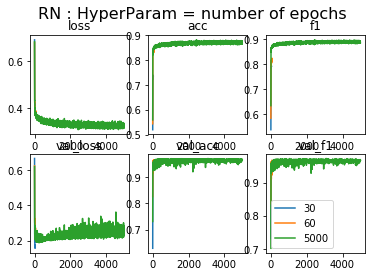

In [6]:
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)

leg = [str(i) for i in epochs_range]                                                                                                                                                
                                                                                                                                       
titre = "RN : HyperParam = number of epochs"                                                                                                                                          

plot_perf(ho, leg, titre ,sub_title)

Nous remarquons que les performances (accuracy et f1_score) tendent vers les mêmes taux qu'il y ait 30, 60 ou 5000 itérations. En revanche, nous remarquons qu'à partir de 1000 itérations, le val_loss augmente. Ceci illustre le surapprentissage. Le nombre optimal d'itérations se situe donc plus autour de 60.

In [ ]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)

Notons ici que les temps d'apprentissage et de prédiction croissent avec le nombre d'itérations.

## Question 5

Finalement, concernant la classification MLP, nous voyons qu'il faut trouver le bon compromis entre le nombre de couches, le nombre de perceptrons et le learning rate.   


| Hyperparamètre        | Nombre d'epochs |Couche Cachées          | Valeur Accuracy (val_acc) | Valeur f1_score (val_f1) | 
|-----------------------|-----------------|------------------------|-----------------|-----------------|
| Nombre de perceptrons | 60              |[5,4,4]                 |0.9411           |0,9478           |
| Nombre de perceptrons | 60              |[100,100,2]             |0.9550           |0.9571           |
| Nombre de perceptrons | 60              |[500,500,500]           |0.9634           |0.9662           |
|-----------------------|-----------------|------------------------|-----------------|-----------------|
| Nombre de couches     | 60              |[100]                   |0.9634           |0.9631           |
| Nombre de couches     | 60              |[100,100,2]             |0.9619           |0.9627           |
| Nombre de couches     | 60              |[100,100,100,100,100,2] |0.9419           |0.9417           |
|-----------------------|-----------------|------------------------|-----------------|-----------------|
| Learning rate (1e-5)  | 60              |[100,100,2]             |0.8553           |0.8594           |
| Learning rate (0.0005)| 60              |[100,100,2]             |0.9600           |0.9604           |
| Learning rate (0.01)  | 60              |[100,100,2]             |0.5191           |0.6815           |
|-----------------------|-----------------|------------------------|-----------------|-----------------|
| Nombre d'epochs       | 30              |[100,100,2]             |0.9563           |0.9577           |
| Nombre d'epochs       | 60              |[100,100,2]             |0.9559           |0.9558           |
| Nombre d'epochs       | 5000            |[100,100,2]             |0.9647           |0.9659           |   


- La meilleure solution pour le nombre de perceptrons par couche cachée est [500,500,500] en terme performance. Néanmoins il est préférable de choisir la solution [100,100,2] qui apporte de meilleures performance temporelles.  
- Le nombre de couche cachée apportant le meilleur compromis est de 3 ([100,100,2]).   
- Le learning rate apportant les meilleurs résultat est : 0.0005.
- Ici nous voyons que 5000 itérations apporte les meilleurs performances, nénanmoins elle apporte du sur apprentissage. De plus, le temps de traitement et d'apprentissage est plus long. Le meilleur compromis est donc de 60 itérations.   

En résumé, la meilleure solution pour le réseau MLP est :  
couche [100,100,2],  
learning rate de 0.0005,  
60 epochs.



## Question 6

L'objectif de la méthode SVM est donc de déterminer des hyperplans séparant les classes avec une marge maximale lorsque les ensembles sont linéairement séparables.
Le paramètre C est un facteur qui permet de pénaliser les points qui sont présents dans la marge. Si le point est présent dans la marge mais dont la prédiction est correcte, on peut affecter un poids entre 0 et 1. Dans notre cas, la meilleure performance est quand le paramètre C vaut 10. Cela veut dire que l'on pénalise très fortement les points dont la prédiction est mauvaise.
Par ailleurs, le paramètre gamma permet de déterminer la taille du noyau lorsque les ensembles ne sont pas linéairement séparables. Il faut néanmoins évaluer ce paramètre avec minutie, car il peut être source de sur apprentissage (quand la valeur de gamma est faible) ou de sous apprentissage (gamma élevé).

Pour l'étude de nos deux classificateurs, nous avons utilisé la même de machine dont les performances sont les suivantes :

Memoire : 15.5GB  
Processor : IntelCore i7-8700 CPU @ 3.2GHz x 12  
Graphics : Titan Xp/PCle/SSE2  
GNOME : 3.28.2  
OS type : 64bit  


In [3]:
X_grid,Y_grid = get_data_GridSearch()
Grid=GridSearch_bestparam(X_grid,Y_grid)

ca commence
best param
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
best score
0.967375


En utilisant l'outil "grid_search" nous obtenons une combinaison des meilleurs paramètres ci-dessus. Nous obtenons dans ce cas une accuracy de plus de 96%.

Analyse Linear


/home/ens/AN03460/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
/home/ens/AN03460/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ens/AN03460/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ens/AN03460/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ens/AN03460/venv/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: get_value is deprecated and will be removed in a future release. Please 

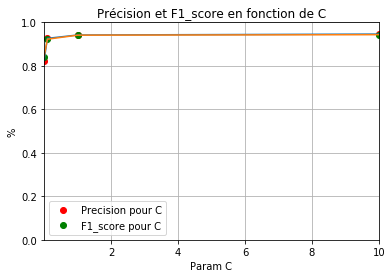

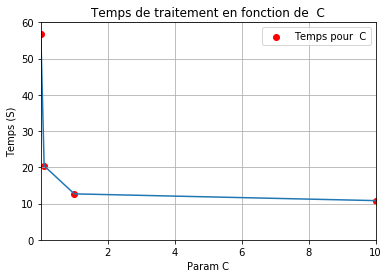

In [21]:
print ('Analyse Linear')
plot_Linear_acc(Grid)

Nous remarquons que l'on obtient rapidement tes performances très satisfaisantes. Par ailleurs, notons que le temps de traitement décroit avec l'augmentation du paramètre C.

Analyse RBF


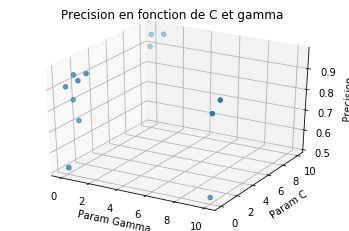

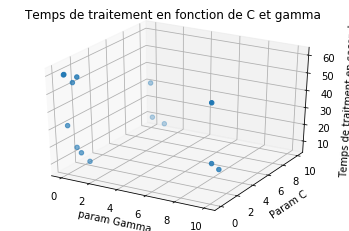

In [7]:
print('Analyse RBF')
plot_RBF_acc(Grid)

On peut également représenter les résultats sous la forme d'un tableau :

In [25]:
print('Table de valeur')

result = Grid.cv_results_
df = pd.DataFrame(data=result)
dfData=df[['param_kernel','param_C','param_gamma','rank_test_Accuracy','mean_test_Accuracy','std_test_Accuracy', 'mean_test_F1','std_test_F1','mean_fit_time', 'std_fit_time','mean_score_time', 'std_score_time']]
dfData= dfData.sort_values(['param_kernel','rank_test_Accuracy','mean_test_F1'],ascending=[True,True,True])
dfData

Table de valeur


,param_kernel,param_C,param_gamma,rank_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,mean_test_F1,std_test_F1,mean_fit_time,std_fit_time,mean_score_time,std_score_time
3,linear,10,NaN,7,0.946063,0.003021,0.947985,0.003004,10.812186,0.912470,1.693979,0.159801
2,linear,1,NaN,9,0.941813,0.003174,0.943939,0.003059,12.676310,0.228588,2.336374,0.082925
1,linear,0.1,NaN,10,0.926500,0.005323,0.929168,0.005085,20.398949,0.679764,4.614898,0.334103
0,linear,0.001,NaN,15,0.823063,0.006238,0.844318,0.005067,56.841637,0.364709,12.590611,0.896276
18,rbf,10,1,1,0.967375,0.002112,0.968615,0.002072,7.057173,0.464026,1.381827,0.136445
14,rbf,1,1,2,0.961375,0.001941,0.962855,0.001872,9.614222,0.311527,2.176467,0.149358
17,rbf,10,0.1,3,0.956250,0.003422,0.957844,0.003256,9.733783,0.502281,2.087624,0.116255
15,rbf,1,10,4,0.952063,0.002334,0.954683,0.002185,20.209869,0.217480,4.897746,0.334222
19,rbf,10,10,5,0.951875,0.002351,0.954324,0.002220,12.342011,1.218828,2.993964,0.296574
10,rbf,0.1,1,6,0.947688,0.004742,0.949900,0.004345,17.304033,0.560825,3.993368,0.169731


In [12]:
print('Résultat de linear avec hyperparametre')
SVCLine(X_train, Y_train, X_test, Y_test,10)

Résultat de linear avec hyperparametre
[[1442   97]
 [  85 1576]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1539
           1       0.94      0.95      0.95      1661

    accuracy                           0.94      3200
   macro avg       0.94      0.94      0.94      3200
weighted avg       0.94      0.94      0.94      3200



In [11]:
print('Résultat de rbf avec hyperparametre')
SVC_rbf(X_train, Y_train, X_test, Y_test,10,1)

Résultat de rbf avec hyperparametre
[[1486   53]
 [  40 1621]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1539
           1       0.97      0.98      0.97      1661

    accuracy                           0.97      3200
   macro avg       0.97      0.97      0.97      3200
weighted avg       0.97      0.97      0.97      3200



## Question 7

Dans le cas du MLP, on remarque que pour 1600 images, le temps d'apprentissage se situe autour de 5 secondes. Pour 16000, le temps d'apprentissage est d'environ 32 secondes. Le temps d'apprentissage est donc bien réduit tandis que le temps de prédiction et les performances ne diminuent pas considérablement avec la taille du dataset d'entrainement.

Dans le cas de SVM, nous avons étudié la double influence des paramètres gamma et C sur le temps d'apprentissage. On remarque alors que ce temps de traitement est le plus élevé dans le cas où les valeurs de C et gamma sont faibles. C'est à dire quand on ne pénalise pas trop les mauvais points et que la taille du noyau est faible, que l'on tend donc vers une situation de sur apprentissage. 

Globalement, les temps d'apprentissages et de prédiction sont du même ordre de grandeur bien que le temps d'apprentissage MLP soit plus faible que celui de SVM qui nécessite plus de calculs (noyau ou transformation non linéaire par exemple). 

## Question 8

Du point de vue des performances, il semblerait que le SVM avec noyau rbf soit le plus adapté avec des performances avoisinant les 97%. En revanche, le temps de traitement est quant à lui beaucoup plus élevé. Dans le cas de classification des galaxies, il n'est pas gênant d'avoir un long temps de traitement.

## Question 9

L'idéal serait de mener une étude plus précise des hyperparamètres pour trouver une solution optimale.
Par ailleurs, il faudrait utiliser des méthodes de validation telle que 5-fold cross validation pour la méthode MLP par exemple. Ceci nous aurait permis d'avoir un meilleur support de comparaison de performance. Par ailleurs, nous avons utilisé l'optimisation Adam qui nous procurait de meilleurs résultats. On pourrait toutefois étudier plus en détail la méthode de descente de gradient à laquelle il faudrait coupler l'étude du pas de descente de gradient.

## Conlusion

Ce troisième laboratoire nous a permis de comprendre davantage le fonctionnement de deux nouvelles méthodes de classification : SVM et MLP. Dans les deux cas, les temps d'apprentissage sont bien plus longs que les premiers laboratoires.  
Dans le cas de MLP nous obtenons des performances qui s'approchent de 95% avec un temps de traitement de l'ordre de la minute. SVM nous apporte de meilleures performances (96%) avec un temps de prédiction similaire, mais un temps d'apprentissage beaucoup plus long. 
Finalement, dans le cas de notre étude le classificateur le plus adapté est donc SVM avec les paramètres étudiés dans la recherche des meilleurs paramètres.
Comme mentionné précédemment, il pourrait être intéressant de tester le modèle MLP avec une validation croisée pour pouvoir comparer au mieux les 2 modèles.